In [1]:
# This will be the next generation of model. The model will aim to include all relief pitchers as well as standardising the data.
# This will model will fork from model v2 and not v3. Normalised did not provide favourable results requiring further reanalysis. 
# Features: Batters: Pitchers:
# Version: 1.0

In [27]:
%load_ext autoreload
%autoreload 2
import import_ipynb
from sklearn import svm
from pymysql import connect
from sys import path
from pathlib import Path
path.append('../../../') 
from BaseballAnalytics.bin.app_utils.queries_vTwo import Queries as Qu_VTwo
from BaseballAnalytics.bin.app_utils.consolidation.consolidating_features import Feature_Consolidater, Feature_Pack
from BaseballAnalytics.bin.app_utils.queries import Queries as Qu
from BaseballAnalytics.bin.app_utils.common_help import Log_Helper
from pickle import dump, load
from traceback import print_exc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Connect to the database.
data_locs = Path(r"C:\Users\micha\Documents\GitHub\BaseballAnalytics\source_data\model_data\model_v2")      # The location of the past queries.
conn = connect(host="localhost", user="root", passwd="praquplDop#odlg73h?c", db="baseball_stats_db")
qu_vTwo = Qu_VTwo(conn)
qu = Qu(conn)

In [4]:
# Get all the game ids with the relevent information attributed to those id. Ensure to get games past May 15.
# The games are returned from earliest played to most recent.
# The 0 at the end indicates a home team victory.
game_outcomes = qu_vTwo.get_game_outcomes(day=15, month=5)            
game_outcomes = game_outcomes[200:]
game_outcomes[0:5]

[('LAN199005020', 1990, 2, 5, 6, 2, 'LAN', 'PIT', 0),
 ('MON199005020', 1990, 2, 5, 1, 8, 'MON', 'ATL', 1),
 ('NYA199005020', 1990, 2, 5, 0, 2, 'NYA', 'OAK', 1),
 ('NYN199005020', 1990, 2, 5, 5, 0, 'NYN', 'CIN', 0),
 ('PHI199005020', 1990, 2, 5, 14, 4, 'PHI', 'HOU', 0)]

In [5]:
# Get the outcomes of all the games.
game_outcomes_all = qu_vTwo.get_game_outcomes()
len(game_outcomes_all)

70101

In [6]:
# Fetch the players, pitchers, and offensive features from all the games.
pitchers_pickle = 'game_pitchers.pickle'
all_pitchers = qu_vTwo.get_pitchers_in_all_games(data_locs / pitchers_pickle)
qu_vTwo.unpack_pitchers(all_pitchers)

An Event ['langm001', '0ANA199704020']
Num Events 46
Num Games 162
Num Years 23
Num Teams 33


In [7]:
# Gather all the relief pitchers. -- POSSIBLE EXCEPTION (NOT ALL GAMES INCLUDED, GAMES MAY BE MISSING DUE TO COMPLETE GAMES)
relief_pitchers = qu_vTwo.get_relief_pitchers(all_pitchers, 25)
print("Games accounted for: {}".format(len(relief_pitchers)))
for game in relief_pitchers:
    print(game)
    print(relief_pitchers[game])
    break

The number of relievers to contian: 3
Games accounted for: 69649
ANA199704020
{'ANA': ['may-d002', 'perct001', 'jamem001'], 'BOS': ['henrb001', 'mahop001', 'sloch001']}


In [8]:
# Gather all the starting pitchers.
starting_pitchers = qu_vTwo.get_starting_pitchers(all_pitchers)
print("Games accounted for: {}".format(len(starting_pitchers)))
for game in starting_pitchers:
    print(game)
    print(starting_pitchers[game])
    break

Games accounted for: 70101
ANA199704020
{'ANA': 'langm001', 'BOS': 'gordt001'}


In [9]:
# Gather all the pitching features from the database.
pitching_feat_pickle = 'raw_pitching_features.pickle'
pitching_features = qu_vTwo.get_all_pitching_features(data_locs / pitching_feat_pickle)
for player_id in pitching_features:
    print(player_id)
    for i, game in enumerate(pitching_features[player_id]):
        print(game)
        if i > 1: break
    break

ackej001
['TEX199004090', 1.0, 2.02, 0.0]
['TOR199004120', 1.5, 1.261, 0.0]
['KCA199004150', 1.333, 2.861, 0.667]


In [10]:
# Acquire all the batters from the database.
batters_pickle = 'game_players.pickle'
all_batters = qu_vTwo.get_batters(data_locs / batters_pickle)
for game_id in all_batters:
    print(game_id)
    for i, event in enumerate(all_batters[game_id]):
        print(event)
        if i > 6: break
    break

ANA199704020
['garcn001', 0, '0ANA199704020']
['pembr001', 0, '10ANA199704020']
['haseb001', 0, '11ANA199704020']
['macks001', 0, '12ANA199704020']
['holld001', 1, '13ANA199704020']
['andeg001', 1, '14ANA199704020']
['murre001', 1, '15ANA199704020']
['leyrj001', 1, '16ANA199704020']


In [11]:
# Acquire all the batters features from the database.
offensive_feat_pickle = 'raw_offensive_features.pickle'
offensive_features = qu_vTwo.get_all_offensive_features(data_locs / offensive_feat_pickle)
for player_id in offensive_features:
    print(player_id)
    for i, game in enumerate(offensive_features[player_id]):
        print(game)
        if i > 1: break
    break

bainh001
['TEX199004090', 0.25, 1.0]
['TOR199004100', 0.25, 0.625]
['TOR199004110', 0.5, 0.625]


In [31]:
# Get the n game rolling average winning perct.
fc = Feature_Consolidater()
winning_pct = fc.get_win_pct(game_outcomes_all)   
for num, i in enumerate(winning_pct):
    print(i)
    print(winning_pct[i])
    if num > 1:
        break

BOS199004090
{'BOS': 0.0, 'DET': 0.0}
CAL199004090
{'CAL': 0.0, 'SEA': 0.0}
CHA199004090
{'CHA': 0.0, 'MIL': 0.0}


In [35]:
features_pickle = data_locs / 'game_features.pickle'
fp = Feature_Pack(game_outcomes, winning_pct, all_batters, offensive_features, all_pitchers, starting_pitchers, relief_pitchers, pitching_features)
X, Y = fc.get_all_game_features(fp, features_pickle, False)
print("\nSample from X:\n")
for num, i in enumerate(X):
    print(i)
    if num > 0:
        break
print("\nSample from Y:\n")
for num, i in enumerate(Y):
    print(i)
    if num > 0:
        break  


Sample from X:

[4.25, 1.263, 2.25, 0.45, 0.3125, 0.29, 0.21666, 0.445, 0.55333, 0.29833, 0.39334, 0.18333, 0.18333, 0.36166, 0.37, 0.38334, 0.43334, 0.325, 0.38334, 0.25, 0.125, 1.0, 1.748, 1.6, 0.8, 2.275, 1.3, 0.6, 1.117, 1.3, 0.5, 4.5, 1.01, 1.75, 0.28333, 0.34833, 0.28999, 0.35, 0.28333, 0.25, 0.24, 0.41, 0.51667, 0.75833, 0.25, 0.26851, 0.39667, 0.48833, 0.29667, 0.225, 0.0, 0.0, 0.2, 1.488, 0.6, 0.3, 2.221, 1.2, 0.8, 1.118, 0.4, 0.8]
[4.5, 1.1, 1.75, 0.355, 0.35667, 0.33333, 0.32666, 0.22222, 0.16667, 0.32167, 0.45, 0.54761, 0.45, 0.05833, 0.08333, 0.1111, 0.1111, 0.38333, 0.47499, 0.5, 0.9, 0.6, 2.587, 1.2, 0.4, 3.429, 1.7, -1.0, -1.0, -1.0, 0.5, 5.0, 1.555, 2.5, 0.215, 0.40166, 0.075, 0.08333, 0.15, 0.225, 0.265, 0.43, 0.39166, 0.46665, 0.12037, 0.09259, 0.33333, 0.41665, 0.32833, 0.42833, 0.0, 0.0, 0.4, 1.552, 1.4, 1.4, 2.431, 1.1, 3.2, 2.067, 3.1, 0.4]

Sample from Y:

0
1


In [14]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Pro

In [15]:
# Split the data for modelling.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, stratify=Y)

In [16]:
sm = svm.SVC(kernel='linear', C=0.01, verbose=True).fit(X_train, y_train)
sm.score(X_test, y_test)

[LibSVM]

0.5511611398438292

In [17]:
rf = RandomForestClassifier(max_depth=15, random_state=0, verbose=True).fit(X_train, y_train)
rf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   31.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


0.5494371767569212

In [18]:
lr = LogisticRegression(max_iter=5000, verbose=True).fit(X_train, y_train)
print(lr.score(X_test, y_test))
print(lr.coef_, lr.intercept_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
0.5494371767569212
[[-8.66587671e-02  3.46274905e-02  3.52579527e-02  1.32981167e-01
  -7.41938512e-02 -2.06985538e-01  2.23964618e-02 -1.14848741e-01
  -1.39479709e-02 -3.12076443e-01  4.99016428e-02 -1.26336243e-01
  -2.09954672e-02 -1.72094502e-02  3.85080891e-02 -4.88774468e-01
   2.11347286e-01 -8.27302934e-02  8.30279531e-02 -1.47076661e-02
  -1.38829929e-01  4.51323423e-03 -3.11914293e-04  7.45517331e-03
   5.14095739e-03  4.58719221e-03  1.75095578e-02 -2.85995009e-02
  -3.52908180e-03  2.34497283e-02 -3.19730098e-01  9.15880161e-02
  -4.05419592e-02 -6.16527179e-02  2.57383690e-01 -1.94981577e-02
  -1.01927539e-01  5.95199319e-02  1.17268562e-01  1.91029095e-02
   2.65489163e-01  3.56889080e-02  5.40815267e-01 -1.18239978e-01
   2.54657217e-01 -5.01464213e-02 -3.83908930e-02  7.54961408e-02
   2.11435485e-01 -3.16893231e-02  4.69411773e-02  9.63667491e-02
   1.21161908e-02 -9.41183951e-03 -5.20568

In [19]:
mlp = MLPClassifier(random_state=1, max_iter=2000, verbose=True).fit(X_train, y_train)
mlp.score(X_test, y_test)

Iteration 1, loss = 0.69312825
Iteration 2, loss = 0.68652764
Iteration 3, loss = 0.68515208
Iteration 4, loss = 0.68542199
Iteration 5, loss = 0.68536023
Iteration 6, loss = 0.68498669
Iteration 7, loss = 0.68395996
Iteration 8, loss = 0.68387623
Iteration 9, loss = 0.68333679
Iteration 10, loss = 0.68401622
Iteration 11, loss = 0.68355109
Iteration 12, loss = 0.68375148
Iteration 13, loss = 0.68283921
Iteration 14, loss = 0.68261249
Iteration 15, loss = 0.68175797
Iteration 16, loss = 0.68173988
Iteration 17, loss = 0.68142764
Iteration 18, loss = 0.68089986
Iteration 19, loss = 0.68046550
Iteration 20, loss = 0.68003873
Iteration 21, loss = 0.67956363
Iteration 22, loss = 0.68037115
Iteration 23, loss = 0.67917895
Iteration 24, loss = 0.67920858
Iteration 25, loss = 0.67851608
Iteration 26, loss = 0.67828663
Iteration 27, loss = 0.67725211
Iteration 28, loss = 0.67744699
Iteration 29, loss = 0.67674862
Iteration 30, loss = 0.67634421
Iteration 31, loss = 0.67601736
Iteration 32, los

0.5226650441131732

Confusion matrix, without normalization
[[3731 1486]
 [2957 1687]]
Normalized confusion matrix
[[0.71516197 0.28483803]
 [0.63673557 0.36326443]]


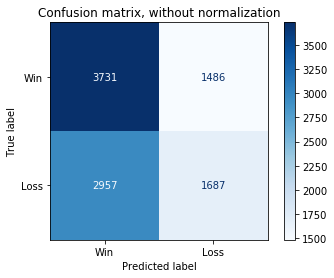

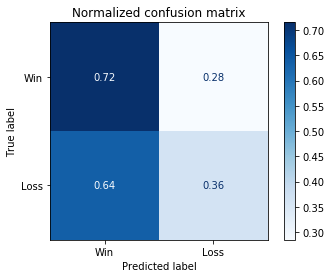

In [20]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=['Win', 'Loss'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [21]:
# Use cross validation to get a better idea of the models success.
from sklearn.model_selection import cross_val_score
lr_cv = LogisticRegression(max_iter=2000)
cv_scores = cross_val_score(lr_cv, X, Y, cv=5)
print(cv_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[0.54164448 0.56126873 0.55564007 0.5557922  0.55058573]
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


In [22]:
rf_cv = RandomForestClassifier(max_depth=15, random_state=0, verbose=True)
cv_scores = cross_val_score(rf_cv, X, Y, cv=5)
print(cv_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   31.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   29.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

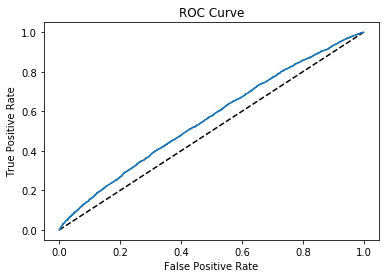

In [23]:
# Build an ROC for the Logistical Regression
# Import necessary modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute predicted probabilities: y_pred_prob
y_pred_prob = lr.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()